In [1]:
import requests
from bs4 import BeautifulSoup
import csv

def scrape_gdp_by_country():
    url = "https://www.worldometers.info/gdp/gdp-by-country/"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    rows = soup.find_all('tr')
    gdp_by_country_data = []

    for row in rows:
        cells = row.find_all('td')
        if len(cells) >= 7:
            country = cells[1].text.strip()
            gdp = cells[2].text.strip().replace('$', '').replace(',', '')
            population = cells[5].text.strip().replace(',', '')
            gdp_per_capita = cells[6].text.strip().replace('$', '').replace(',', '')
            gdp_by_country_data.append((country, gdp, population, gdp_per_capita))
    
    return gdp_by_country_data

def merge_with_country_nationality_mapping(gdp_data, country_nationality_file):
    country_nationality_map = {}
    with open(country_nationality_file, 'r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            country_name = row['en_short_name']
            nationality = row['nationality']
            country_nationality_map[country_name] = nationality

    merged_data = []
    for country, gdp, population, gdp_per_capita in gdp_data:
        if country in country_nationality_map:
            nationality = country_nationality_map[country]
            merged_data.append((country, nationality, gdp, population, gdp_per_capita))
        else:
            merged_data.append((country, '', gdp, population, gdp_per_capita))

    return merged_data

def write_to_csv(data, csv_file):
    with open(csv_file, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Country', 'Nationality', 'GDP', 'Population', 'GDP per Capita'])
        writer.writerows(data)

def main():
    gdp_by_country_data = scrape_gdp_by_country()
    if gdp_by_country_data:
        merged_data = merge_with_country_nationality_mapping(gdp_by_country_data, 'Data/countries.csv')
        write_to_csv(merged_data, 'Data/merged_gdp_data.csv')

if __name__ == "__main__":
    main()


In [2]:
import csv

# Read data from the primary CSV file
primary_data = {}
with open('Data/merged_gdp_data.csv', 'r', newline='', encoding='utf-8') as primary:
    reader = csv.DictReader(primary)
    for row in reader:
        key = row['Nationality']
        primary_data[key] = row

# Merge data from the secondary CSV file based on the "Nationality" column
merged_data = []
with open('Data/EU_students_acceptance_by_department.csv', 'r', newline='', encoding='utf-8') as secondary:
    reader = csv.DictReader(secondary)
    for row in reader:
        key = row['Nationality']
        if key in primary_data:
            primary_row = primary_data[key]
            merged_row = {**primary_row, **row}
            merged_data.append(merged_row)

# Write the merged data to a new CSV file
headers = merged_data[0].keys()
with open('Data/merged_data_with_students.csv', 'w', newline='', encoding='utf-8') as output:
    writer = csv.DictWriter(output, fieldnames=headers)
    writer.writeheader()
    writer.writerows(merged_data)


In [8]:
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import plotly.graph_objects as go

# Load the data
file_path = 'Data/merged_data_with_students.csv'
merged_data = pd.read_csv(file_path)

# Group by country and sum the applications for 2020 and 2022
country_totals = merged_data.groupby('Country').agg({'Applications 2020': 'sum', 'Applications 2022': 'sum', 'GDP per Capita': 'first'})

# Calculate the difference between applications in 2022 and 2020 for each country
country_totals['Difference'] = country_totals['Applications 2022'] - country_totals['Applications 2020']

# Reset index to make 'Country' a regular column
country_totals.reset_index(inplace=True)

# Plotting using Plotly Express
fig = px.scatter(country_totals, x='GDP per Capita', y='Difference', title='Difference in Applications between 2022 and 2020 by GDP per Capita',
                 labels={'Difference': 'Difference in Applications' , 'GDP per Capita': 'GDP per Capita'}, hover_name='Country')

# Add OLS regression line
x = sm.add_constant(country_totals['GDP per Capita'])
model = sm.OLS(country_totals['Difference'], x).fit()
fig.add_traces(go.Scatter(x=country_totals['GDP per Capita'], y=model.predict(), mode='lines', name='OLS Regression'))

# Show the plot
fig.show()


## Interpretation of the Scatter Plot

We now take a look at individual countries from the European Union. We want to find out in what way their characteristics play a role in the influence of the Brexit referendum on the applicants of LSE. If, in fact, higher tuition fees play a role in the financial decision-making process of applicants, it is likely that we see a bigger decline in applicants in poorer countries. The figure above plots the GDP per capita of EU member states against the difference in applications. We use GDP per capita instead of GDP as it speaks better to the financial backgrounds and incentives of potential applicants. The difference in applications is a metric which we calculate by summing all applications of said country from 2022 and subtracting all applications from 2020. We thus receive the increase or decrease in applicants over Brexit. Note that our analysis again skips the year 2021 in order to exclude the COVID-19 pandemic as a possible confounder. Every data point in the plot represents one country. Fitting an OLS line through the data reveals indeed a slight positive correlation between GDP per capita and the difference in applications. This means that countries with a higher GDP per capita on average experienced a smaller decline in applications from their citizens to LSE. This could indeed be due to insufficient financial funds. We must also consider here that poorer applicants are probably more likely to receive a scholarship, leading our estimate to be biased downward. This means that excluding the possibilities of scholarships, we would see an even steeper decline in applications from poorer countries if fees are raised.

In [4]:
import pandas as pd

# Load the data
file_path = 'Data/merged_data_with_students.csv'
merged_data = pd.read_csv(file_path)

# Sort the countries by GDP per capita in descending order
sorted_data = merged_data.sort_values(by='GDP per Capita', ascending=False)

# Calculate the total population
total_population = sorted_data['Population'].sum()

# Find the index where the cumulative population crosses half of the total population
half_population = total_population / 2
cumulative_population = 0
rich_countries_set = set()
poor_countries_set = set()

for index, row in sorted_data.iterrows():
    cumulative_population += row['Population']
    if cumulative_population >= half_population:
        break
    rich_countries_set.add(row['Country'])

# Poorer half countries
poor_countries_set = set(sorted_data[~sorted_data['Country'].isin(rich_countries_set)]['Country'])

# Convert sets to lists
rich_countries = list(rich_countries_set)
poor_countries = list(poor_countries_set)

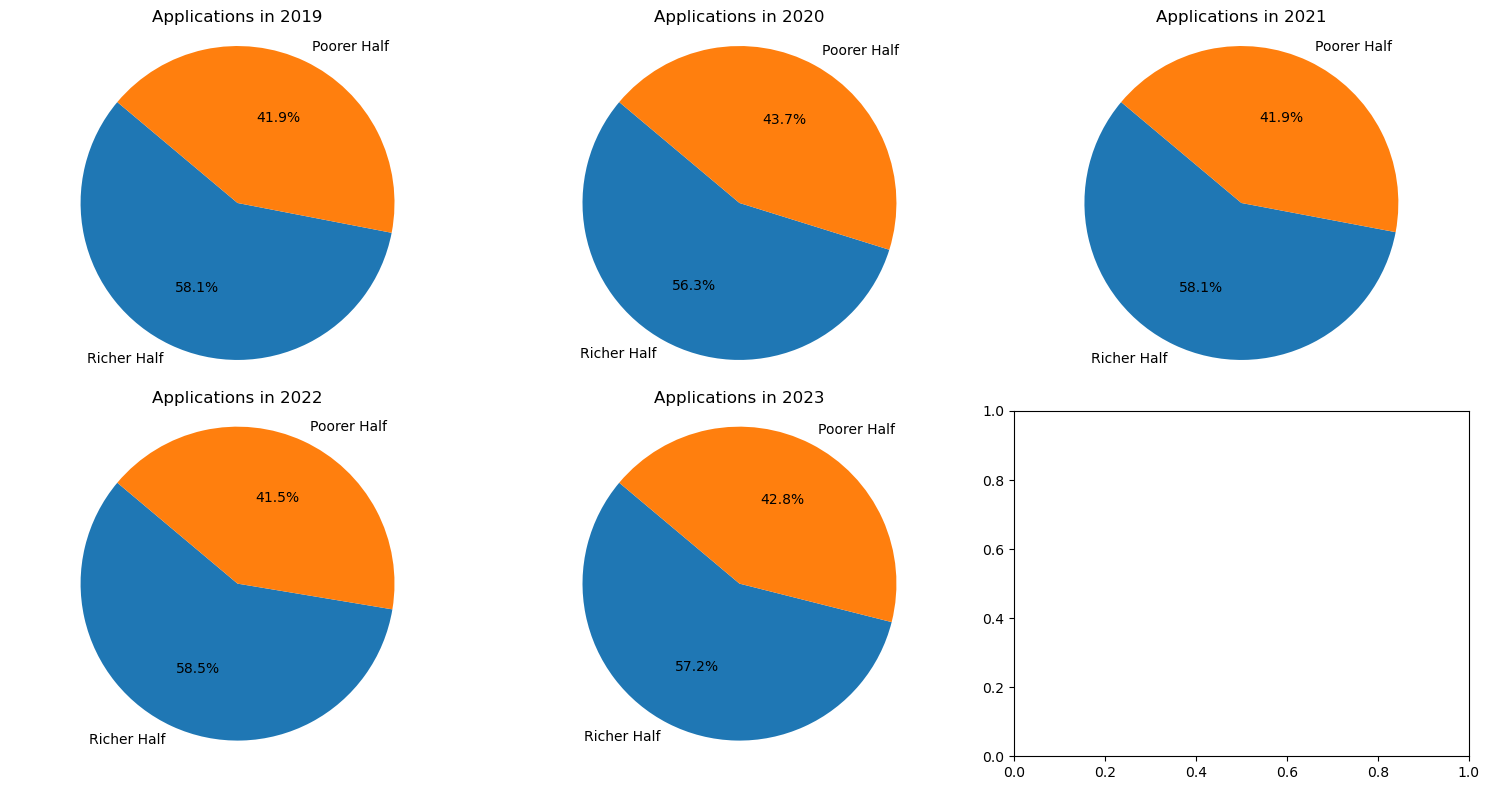

In [5]:
import matplotlib.pyplot as plt

# Initialize variables to store total applications for rich and poor countries for each year
rich_total_applications = {}
poor_total_applications = {}

# Iterate over each year
for year in range(2019, 2024):
    rich_sum = 0
    poor_sum = 0
    
    # Iterate over richer half countries
    for country in rich_countries:
        # Filter data for the current country and year
        country_data = merged_data[(merged_data['Country'] == country)]
        
        # Add the applications for the current country and year to the sum
        rich_sum += country_data[f'Applications {year}'].sum()
    
    # Iterate over poorer half countries
    for country in poor_countries:
        # Filter data for the current country and year
        country_data = merged_data[(merged_data['Country'] == country)]
        
        # Add the applications for the current country and year to the sum
        poor_sum += country_data[f'Applications {year}'].sum()
    
    # Store the total applications for the current year
    rich_total_applications[year] = rich_sum
    poor_total_applications[year] = poor_sum

# Now, rich_total_applications and poor_total_applications contain the total applications for each year
# for the richer half and poorer half countries, respectively.

# Plotting pie charts for each year
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Iterate over each year
for i, year in enumerate(range(2019, 2024)):
    # Data for the current year
    rich_applications = rich_total_applications[year]
    poor_applications = poor_total_applications[year]
    
    # Labels for the pie chart
    labels = ['Richer Half', 'Poorer Half']
    
    # Sizes for the pie chart
    sizes = [rich_applications, poor_applications]
    
    # Plotting the pie chart
    row = i // 3
    col = i % 3
    axs[row, col].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    axs[row, col].set_title(f'Applications in {year}')

# Show the pie charts
plt.tight_layout()
plt.show()


## Analysis of pie charts

In this analysis, we partitioned the population of the European Union into two halves based on GDP per capita: one comprising countries with higher GDP per capita and the other their counterparts. Both groups are of roughly equal size in terms of population and would ideally yield a comparable number of applicants were it not for the economic disparities among their respective countries. Our objective is to discern whether there exists a general effect attributable to wealthiness and whether there is an effect stemming from Brexit.

Initially, it is apparent that the "Richer Half" accounts for a higher proportion of applications, hovering around 58 percent. However, there is no discernible trend in these percentages over the past five years. While lacking a clear trajectory, this figure furnishes valuable insights that inform the interpretation of our data. Specifically, it underscores that the half of the population originating from wealthier EU countries yields a greater number of applicants. Consequently, this observation strongly suggests that financial considerations significantly influence application decisions. Nevertheless, it is important to acknowledge the presence of numerous confounding factors that complicate this interpretation.

For instance, wealthier countries may boast superior education systems on average, thereby increasing the likelihood of their citizens applying to prestigious foreign universities such as LSE. Additionally, as mentioned previously, the issue of scholarships introduces a downward bias to our estimates, further complicating the analysis.

In [9]:
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import plotly.graph_objects as go

# Group by country and sum the applications for 2020 and 2022
country_totals = merged_data.groupby('Country').agg({'Entrances 2020': 'sum', 'Entrances 2022': 'sum', 'GDP per Capita': 'first'})

# Calculate the difference between applications in 2022 and 2020 for each country
country_totals['Difference'] = country_totals['Entrances 2022'] - country_totals['Entrances 2020']

# Reset index to make 'Country' a regular column
country_totals.reset_index(inplace=True)

# Plotting using Plotly Express
fig = px.scatter(country_totals, x='GDP per Capita', y='Difference', title='Difference in Entrances between 2020 and 2022 by GDP per Capita',
                 labels={'Difference': 'Difference in Entrances between 2020 and 2022', 'GDP per Capita': 'GDP per Capita'}, hover_name='Country')

# Add OLS regression line
x = sm.add_constant(country_totals['GDP per Capita'])
model = sm.OLS(country_totals['Difference'], x).fit()
fig.add_traces(go.Scatter(x=country_totals['GDP per Capita'], y=model.predict(), mode='lines', name='OLS Regression'))

# Show the plot
fig.show()

## Interpretation of the scatter plot



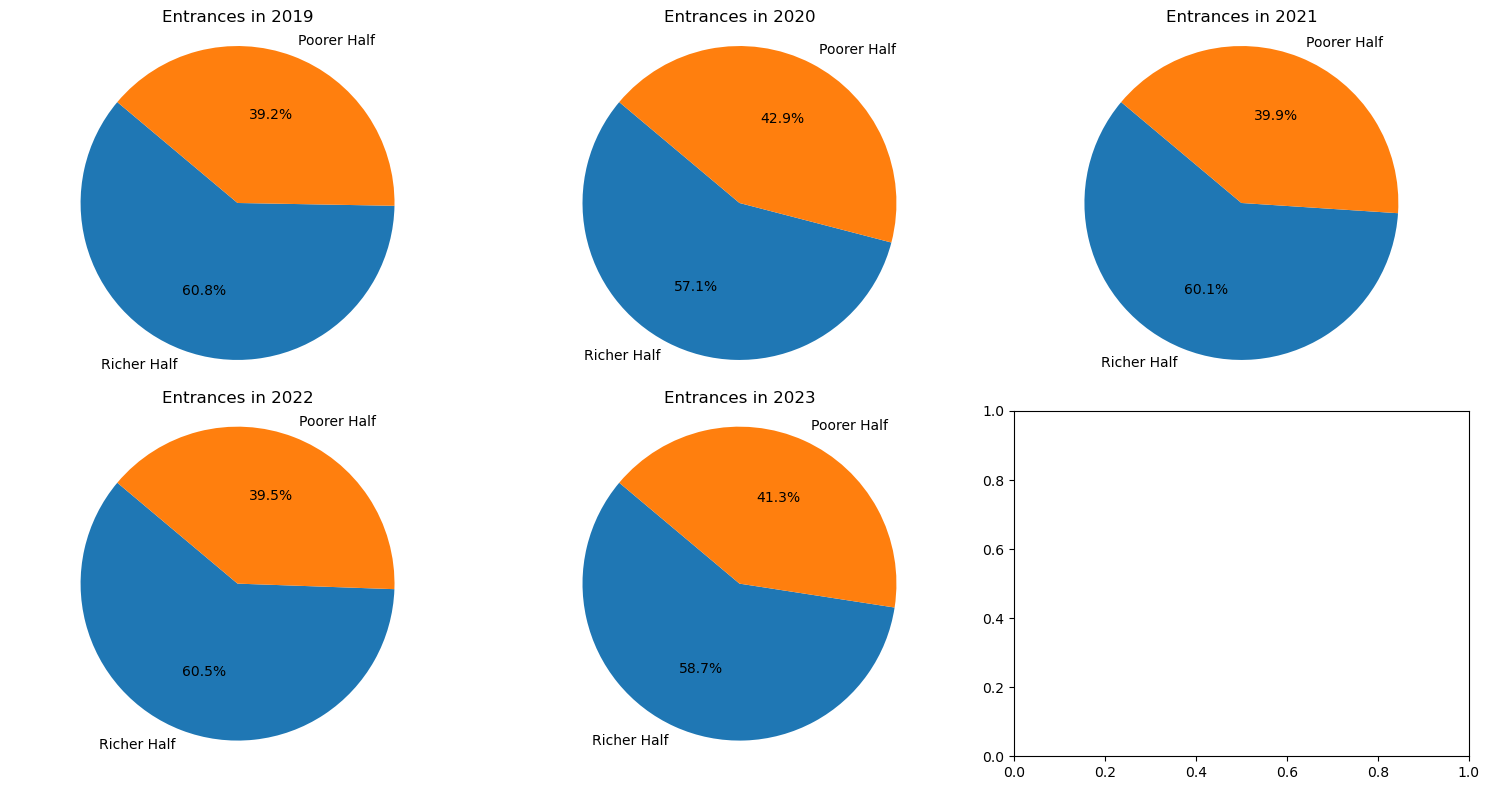

In [7]:
import matplotlib.pyplot as plt

# Initialize variables to store total applications for rich and poor countries for each year
rich_total_entrances = {}
poor_total_entrances = {}

# Iterate over each year
for year in range(2019, 2024):
    rich_sum = 0
    poor_sum = 0
    
    # Iterate over richer half countries
    for country in rich_countries:
        # Filter data for the current country and year
        country_data = merged_data[(merged_data['Country'] == country)]
        
        # Add the applications for the current country and year to the sum
        rich_sum += country_data[f'Entrances {year}'].sum()
    
    # Iterate over poorer half countries
    for country in poor_countries:
        # Filter data for the current country and year
        country_data = merged_data[(merged_data['Country'] == country)]
        
        # Add the applications for the current country and year to the sum
        poor_sum += country_data[f'Entrances {year}'].sum()
    
    # Store the total applications for the current year
    rich_total_applications[year] = rich_sum
    poor_total_applications[year] = poor_sum

# Now, rich_total_applications and poor_total_applications contain the total applications for each year
# for the richer half and poorer half countries, respectively.

# Plotting pie charts for each year
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Iterate over each year
for i, year in enumerate(range(2019, 2024)):
    # Data for the current year
    rich_applications = rich_total_applications[year]
    poor_applications = poor_total_applications[year]
    
    # Labels for the pie chart
    labels = ['Richer Half', 'Poorer Half']
    
    # Sizes for the pie chart
    sizes = [rich_applications, poor_applications]
    
    # Plotting the pie chart
    row = i // 3
    col = i % 3
    axs[row, col].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    axs[row, col].set_title(f'Entrances in {year}')

# Show the pie charts
plt.tight_layout()
plt.show()